In [68]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import sys
sys.path.append(r'D:\kasia\tracking\E6_exp\code\tracks_interactions')
from tracks_interactions.db.db_model import NO_PARENT, CellDB, TrackDB
import dask.array as da
import napari
import numpy as np
import os
os.environ['NAPARI_PERFMON'] = '0'
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# get access to the database
db_path = r'D:\kasia\tracking\E6_exp\double_segmentation_ultrack\Exp6_gardener_example_to_process.db'
engine = create_engine(f'sqlite:///{db_path}')
session = sessionmaker(bind=engine)()

from sqlalchemy import text
session.execute(text("ANALYZE;"))
session.commit()

In [3]:
t=session.query(TrackDB).filter(TrackDB.accepted_tag == True).all()

In [6]:
cells=session.query(CellDB).filter_by(track_id = t[0].track_id).order_by(CellDB.t).all()
cells[0].signals

{'area': 252,
 'ch0_nuc': 3953.1825396825398,
 'ch0_cyto': 2443.0997229916898,
 'ch1_nuc': 1865.5833333333333,
 'ch1_cyto': 273.33240997229916}

In [19]:
signals = []
tag_list = []
for cell_num in range(len(t)):

    # find cell id
    track_id = t[cell_num].track_id

    # get all cells from the track
    cells=session.query(CellDB).filter_by(track_id = track_id).order_by(CellDB.t).all()

    tag = ''
    for cell in cells:
        if cell.tags.get('apoptosis', False):
            tag='_apo'
            break
        if cell.tags.get('mitosis', False):
            tag='_mit'
            break
    

    # get signal
    s = []
    for cell in cells:
        s.append(cell.signals['ch0_cyto']/cell.signals['ch0_nuc'])
    s = np.array(s)

    if len(s) > 50:
        signals.append(s)
        tag_list.append(tag)

In [21]:
max_len = 0
for s in signals:
    max_len = max(max_len, len(s))
print(max_len)

240


In [22]:
signals_apo = [signals[i] for i in range(len(signals)) if tag_list[i] == '_apo']   
print(len(signals_apo))
signals_senes = [signals[i] for i in range(len(signals)) if tag_list[i] == '']
print(len(signals_senes))

9
7


In [33]:
# make a 2D array
signals2D = np.zeros((len(signals_apo)+len(signals_senes), max_len))

i = 0
for s in signals_apo:
    start_index = max_len - len(s)  
    signals2D[i, start_index:] = s
    #signals2D[i, :len(s)] = s
    i+=1

for s in signals_senes:
    start_index = max_len - len(s)  
    signals2D[i, start_index:] = s
    #signals2D[i, :len(s)] = s
    i+=1

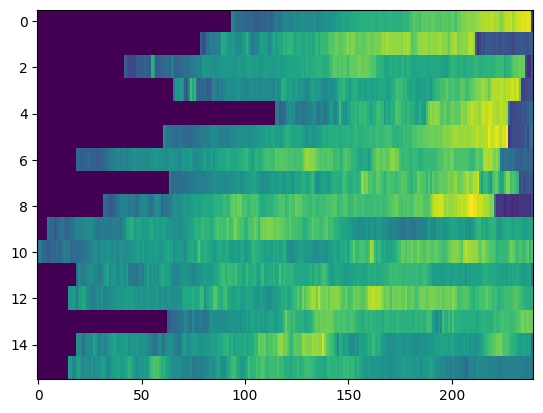

In [34]:
# create a heatmap with matplotlib
plt.imshow(signals2D, aspect='auto', cmap='viridis',interpolation='nearest')


In [47]:
# data cleaning
signals_apo_cut = []
for s in signals_apo:
    st  = len(s)/2
    for i in range(int(st), len(s)-1):
        if s[i] < 0.7:
            break
    s = s[:i]
    signals_apo_cut.append(s)


In [48]:
# make a 2D array
signals2D_cut = np.zeros((len(signals_apo)+len(signals_senes), max_len))

i = 0
for s in signals_apo_cut:
    start_index = max_len - len(s)  
    signals2D_cut[i, start_index:] = s
    i+=1

for s in signals_senes:
    start_index = max_len - len(s)  
    signals2D_cut[i, start_index:] = s
    i+=1

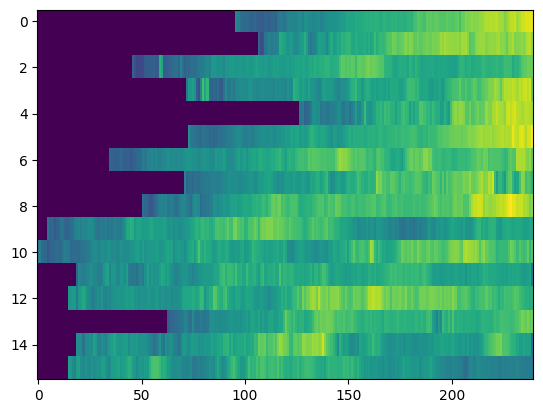

In [49]:
# create a heatmap with matplotlib
plt.imshow(signals2D_cut, aspect='auto', cmap='viridis',interpolation='nearest')

In [50]:
# compare mean of last 5 frames
mean_apo = [np.mean(s[-5:]) for s in signals_apo_cut]
mean_senes = [np.mean(s[-5:]) for s in signals_senes]

In [51]:
mean_apo

[1.5530432949418471,
 1.4021124788828276,
 1.2510181125906876,
 1.4483078695462313,
 1.4402411484526871,
 1.5262739001398262,
 1.3384360419357915,
 1.173155310891623,
 1.381472615679966]

In [64]:
df_apo = pd.DataFrame(mean_apo,columns=['mean'])
df_apo['condition']='apo'
df_senes = pd.DataFrame(mean_senes,columns=['mean'])
df_senes['condition']='senes'
df = pd.concat([df_apo, df_senes],ignore_index=True)

In [65]:
df

,mean,condition
0,1.553043,apo
1,1.402112,apo
2,1.251018,apo
3,1.448308,apo
4,1.440241,apo
5,1.526274,apo
6,1.338436,apo
7,1.173155,apo
8,1.381473,apo
9,0.944494,senes


<Axes: xlabel='condition', ylabel='mean'>

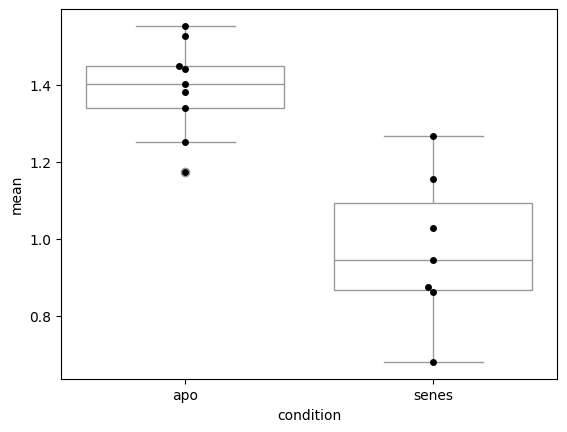

In [74]:
sns.boxplot(data=df, x='condition', y='mean',color='white')
sns.swarmplot(data=df, x='condition', y='mean',color='black')

In [75]:
from scipy.stats import ttest_ind
ttest_ind(mean_apo, mean_senes)

TtestResult(statistic=5.224304081149904, pvalue=0.00012874053835786983, df=14.0)